In [1]:
import re
import numpy as np
import pandas as  pd
from pprint import pprint# Gensim
import gensim
import gensim.corpora as corpora
import gensim.models as genmodels
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pickle
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt

import networkx as nx
import plotly.graph_objects as go


d:\Eskwelabs\sprint4\dsf-c10-sprint-4\code-along\scripting_101\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [2]:
df_kp = pd.read_csv("sample_clean_kawaling_pinoy.csv")[["food","ingredients"]]
df_pp = pd.read_csv("sample_clean_panlasang_pinoy.csv")[["food","ingredients"]]
df_pp.dropna(inplace=True)

df=pd.concat([df_kp,df_pp], axis=0).reset_index(drop=True)
df



,food,ingredients
0,Ginisang Pusit,"2 pounds squid, 1/2 cup vinegar, 4 cloves garl..."
1,Polvoron,"2 cups flour, 1 cup powdered full cream milk (..."
2,Ube Maja Blanca,"2 cups coconut cream, 2 cans (13.5 ounces each..."
3,Adobong Talaba,"1 tablespoon canola oil, 2 tablespoons butter,..."
4,Miswa at Patola Soup,"3 medium patola, 1 tablespoon canola oil, 1 on..."
...,...,...
1559,Pork with Salted Black Beans,"1 lb. pork tenderloin sliced into thin strips,..."
1560,Misua with Patola and Shrimp,"1 medium sized patola sponge gourd, peeled and..."
1561,Pata Pochero Recipe,"3 lbs. Pig's leg pata, cut in 2 ½ inches lengt..."
1562,Basil Chicken Recipe,"1 lb. ground chicken breast, 12 to 15 pieces f..."


## Stop words

In [3]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

additional_stopwords=["tablespoon","teaspoon","cup","water","gram","piece","recipe","can","taste","lb","ounce","pound","purpose"]


# Add the singular versions of the additional stopwords to the list
stop_words.extend([word for word in additional_stopwords if word.endswith("s")])

# Add the plural versions of the additional stopwords to the list
stop_words.extend([word+"s" for word in additional_stopwords if not word.endswith("s")])

stop_words.extend(additional_stopwords)
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [4]:


# pattern = '|'.join(additional_stopwords)
# df1=df[["ingredients"]].dropna()
# df1["ingredients"]= df1["ingredients"].replace(25.0, "Twenty five")
# #df1=df1[~df1.ingredients.str.contains(pattern)]
# df1.str.replace("")


In [5]:
# Convert to list 
data = df.ingredients.values.tolist()  
# # Remove Emails 
# data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]  
# # Remove new line characters 
# data = [re.sub('\s+', ' ', sent) for sent in data]  
# # Remove distracting single quotes 
# data = [re.sub("\'", "", sent) for sent in data]
# #Remove \n
# data = [re.sub("\n", "", sent) for sent in data]
# data = [re.sub("(Image courtesy: )", "", sent) for sent in data]
# #Remove links
# data = [re.sub(r'http\S+', '', sent) for sent in data]

#Remove whitespace
data = [re.sub(r"^\s+|\s+$", "", sent) for sent in data]

display(len(data))
print(data[8])

1564

1 tablespoon canola oil, 1 onion, peeled and chopped, 4 cloves garlic, peeled and minced, 3 pounds bone-in chicken parts (wings, thighs, breast), 12 cups boiling water, 1 teaspoon pepper corns, 2 bay leaves, 1 tablespoon salt, 1 pound ground pork, 1/2 cup green onions, finely chopped, 1/2 cup water chestnuts, finely chopped, 1 small carrot, peeled and shredded, 3 cloves garlic, peeled and minced, 1 teaspoon soy sauce, 1 teaspoon salt, 1/2 teaspoon pepper, 30 pieces Molo or wonton wrappers, 1 tablespoon canola oil, 1 onion, peeled and sliced thinly, 2 cloves garlic, peeled and minced, 1 tablespoon fish sauce, 10 cups homemade broth, salt and pepper to taste, green onions, chopped, fried garlic bits


### Tokenization

In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))            #deacc=True removes punctuations

data_words = list(sent_to_words(data))
print(data_words[:9]) 

[['pounds', 'squid', 'cup', 'vinegar', 'cloves', 'garlic', 'peeled', 'and', 'minced', 'teaspoon', 'peppercorns', 'cracked', 'bay', 'leaf', 'tablespoons', 'canola', 'oil', 'onion', 'peeled', 'and', 'thinly', 'sliced', 'large', 'roma', 'tomatoes', 'chopped', 'tablespoon', 'fish', 'sauce', 'salt', 'and', 'pepper', 'to', 'taste'], ['cups', 'flour', 'cup', 'powdered', 'full', 'cream', 'milk', 'nido', 'cup', 'sugar', 'cup', 'butter', 'melted', 'cup', 'pinipig', 'cup', 'unsalted', 'cashew', 'or', 'peanut', 'oreo', 'cookies', 'tablespoon', 'butter', 'melted'], ['cups', 'coconut', 'cream', 'cans', 'ounces', 'each', 'coconut', 'milk', 'can', 'ounces', 'sweetened', 'condensed', 'milk', 'can', 'ounces', 'evaporated', 'milk', 'cups', 'cooked', 'ube', 'mashed', 'cup', 'sugar', 'drops', 'ube', 'extract', 'cup', 'water', 'cup', 'cornstarch'], ['tablespoon', 'canola', 'oil', 'tablespoons', 'butter', 'onion', 'peeled', 'and', 'chopped', 'cloves', 'garlic', 'peeled', 'and', 'minced', 'thumb', 'size', 'gi

### Building the bigram and trigram Models

In [7]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)


In [8]:
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[8]]])

['tablespoon', 'canola', 'oil', 'onion', 'peeled', 'and', 'chopped', 'cloves', 'garlic', 'peeled', 'and', 'minced', 'pounds', 'bone', 'in', 'chicken', 'parts', 'wings', 'thighs', 'breast', 'cups', 'boiling', 'water', 'teaspoon', 'pepper', 'corns', 'bay', 'leaves', 'tablespoon', 'salt', 'pound', 'ground', 'pork', 'cup', 'green', 'onions', 'finely', 'chopped', 'cup', 'water', 'chestnuts', 'finely', 'chopped', 'small', 'carrot', 'peeled', 'and', 'shredded', 'cloves', 'garlic', 'peeled', 'and', 'minced', 'teaspoon', 'soy', 'sauce', 'teaspoon', 'salt', 'teaspoon', 'pepper', 'pieces', 'molo', 'or', 'wonton', 'wrappers', 'tablespoon', 'canola', 'oil', 'onion', 'peeled', 'and', 'sliced', 'thinly', 'cloves', 'garlic', 'peeled', 'and', 'minced', 'tablespoon', 'fish', 'sauce', 'cups', 'homemade', 'broth', 'salt', 'and', 'pepper', 'to', 'taste', 'green', 'onions', 'chopped', 'fried', 'garlic', 'bits']


In [9]:
data_words

[['pounds',
  'squid',
  'cup',
  'vinegar',
  'cloves',
  'garlic',
  'peeled',
  'and',
  'minced',
  'teaspoon',
  'peppercorns',
  'cracked',
  'bay',
  'leaf',
  'tablespoons',
  'canola',
  'oil',
  'onion',
  'peeled',
  'and',
  'thinly',
  'sliced',
  'large',
  'roma',
  'tomatoes',
  'chopped',
  'tablespoon',
  'fish',
  'sauce',
  'salt',
  'and',
  'pepper',
  'to',
  'taste'],
 ['cups',
  'flour',
  'cup',
  'powdered',
  'full',
  'cream',
  'milk',
  'nido',
  'cup',
  'sugar',
  'cup',
  'butter',
  'melted',
  'cup',
  'pinipig',
  'cup',
  'unsalted',
  'cashew',
  'or',
  'peanut',
  'oreo',
  'cookies',
  'tablespoon',
  'butter',
  'melted'],
 ['cups',
  'coconut',
  'cream',
  'cans',
  'ounces',
  'each',
  'coconut',
  'milk',
  'can',
  'ounces',
  'sweetened',
  'condensed',
  'milk',
  'can',
  'ounces',
  'evaporated',
  'milk',
  'cups',
  'cooked',
  'ube',
  'mashed',
  'cup',
  'sugar',
  'drops',
  'ube',
  'extract',
  'cup',
  'water',
  'cup',
  'c

### Define function for stopwords, bigrams, trigrams and lemmatization

In [10]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

#allowed_postags=['NOUN','ADJ', 'VERB', 'ADV']
def lemmatization(texts, allowed_postags=['NOUN','ADJ']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
data_words_trigrams = make_trigrams(data_words_nostops)


In [12]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en

#nlp = spacy.load('en_core_web_lg')
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])


# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized_bi = lemmatization(data_words_bigrams, allowed_postags=['NOUN'])
data_lemmatized_tri = lemmatization(data_words_trigrams, allowed_postags=['NOUN'])
print(data_lemmatized_bi[-1])

d:\Eskwelabs\sprint4\dsf-c10-sprint-4\code-along\scripting_101\lib\site-packages\spacy\language.py:1895: UserWarning: [W123] Argument disable with value ['parser', 'ner'] is used instead of ['senter'] as specified in the config. Be aware that this might affect other components in your pipeline.
  warnings.warn(


['chicken', 'breast', 'head', 'broccoli', 'floret', 'medium', 'onion', 'ginger', 'garlic', 'powder', 'cornstarch', 'egg', 'oyster', 'sauce', 'soy', 'sauce', 'cornstarch', 'oil', 'salt', 'pepper']


In [13]:
id2word_bi = corpora.Dictionary(data_lemmatized_bi)  
id2word_tri = corpora.Dictionary(data_lemmatized_tri)  

In [14]:
texts_bi = data_lemmatized_bi
texts_tri = data_lemmatized_tri

In [15]:
# Term Document Frequency 
corpus_bi = [id2word_bi.doc2bow(text) for text in texts_bi]  
corpus_tri = [id2word_tri.doc2bow(text) for text in texts_tri]  

In [16]:
# View 
print(corpus_bi[:8])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)], [(10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1)], [(11, 1), (13, 3), (15, 1), (16, 2), (17, 1), (18, 1)], [(2, 1), (3, 1), (7, 1), (8, 1), (10, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1)], [(0, 1), (2, 1), (3, 1), (4, 1), (7, 1), (25, 1), (26, 1), (27, 1)], [(11, 1), (13, 1), (15, 1), (16, 2), (28, 1), (29, 2), (30, 1)], [(11, 1), (12, 1), (13, 1), (15, 1), (16, 2), (31, 1), (32, 1), (33, 1)], [(2, 1), (4, 1), (8, 1), (24, 1), (27, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1)]]


In [17]:
[[(id2word_bi[id], freq) for id, freq in cp] for cp in corpus_bi[:1]]
[[(id2word_tri[id], freq) for id, freq in cp] for cp in corpus_tri[:1]]

[[('fish', 1),
  ('leaf', 1),
  ('oil', 1),
  ('onion', 1),
  ('pepper', 1),
  ('peppercorn', 1),
  ('roma_tomatoe', 1),
  ('salt', 1),
  ('sauce', 1),
  ('vinegar', 1)]]

<AxesSubplot: ylabel='word'>

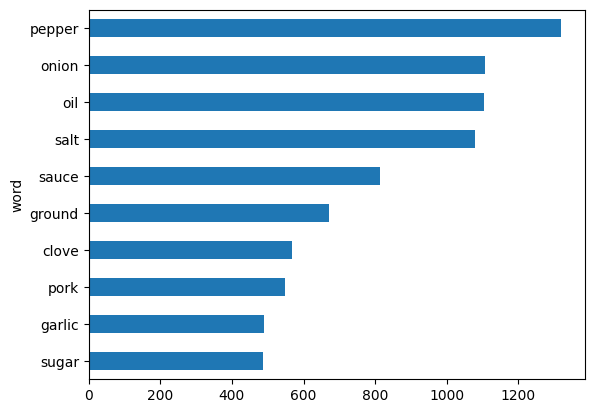

In [18]:
bow=[[(id2word_tri[id], freq) for id, freq in cp] for cp in corpus_tri]
flat_list = [item for sublist in bow for item in sublist]


#no_value_words=["stay","good","hotel","place","nice","great"]

df_bow = pd.DataFrame(flat_list, columns = ['word', 'count'])
#df_bow=df_bow[~df_bow.word.str.contains('|'.join(no_value_words))] 
df_bow.groupby("word")["count"].sum().sort_values(ascending=True).tail(10).plot.barh()

In [19]:
data_lemmatized_tri

[['vinegar',
  'peppercorn',
  'leaf',
  'oil',
  'onion',
  'roma_tomatoe',
  'fish',
  'sauce',
  'salt',
  'pepper'],
 ['flour', 'cream', 'milk', 'sugar', 'butter', 'pinipig'],
 ['coconut',
  'cream',
  'coconut',
  'milk',
  'milk',
  'milk',
  'sugar',
  'extract',
  'cornstarch'],
 ['oil',
  'butter',
  'onion',
  'clove',
  'garlic',
  'ginger',
  'oyster',
  'meat',
  'soy',
  'sauce',
  'salt'],
 ['oil', 'onion', 'ground', 'pork', 'fish', 'noodle', 'salt', 'pepper'],
 ['corn',
  'cobs',
  'corn',
  'kernel',
  'coconut',
  'milk',
  'coconut',
  'cream',
  'sugar'],
 ['rice',
  'flour',
  'coconut',
  'milk',
  'camote',
  'saba_banana',
  'coconut',
  'cream',
  'sugar'],
 ['center',
  'pork',
  'loin',
  'rib',
  'chop',
  'bone',
  'inch',
  'pepper',
  'soy',
  'sauce',
  'calamansi',
  'juice',
  'canola',
  'oil'],
 ['oil',
  'onion',
  'clove',
  'garlic',
  'bone',
  'chicken',
  'part',
  'wing',
  'thigh',
  'breast',
  'salt',
  'ground',
  'pork',
  'onion',
  'che

In [20]:
pd.DataFrame(data_lemmatized_tri)
data_lemmatized_tri
ingredients_list = [",".join(ingredients) for ingredients in data_lemmatized_tri]

ingredients_list

['vinegar,peppercorn,leaf,oil,onion,roma_tomatoe,fish,sauce,salt,pepper',
 'flour,cream,milk,sugar,butter,pinipig',
 'coconut,cream,coconut,milk,milk,milk,sugar,extract,cornstarch',
 'oil,butter,onion,clove,garlic,ginger,oyster,meat,soy,sauce,salt',
 'oil,onion,ground,pork,fish,noodle,salt,pepper',
 'corn,cobs,corn,kernel,coconut,milk,coconut,cream,sugar',
 'rice,flour,coconut,milk,camote,saba_banana,coconut,cream,sugar',
 'center,pork,loin,rib,chop,bone,inch,pepper,soy,sauce,calamansi,juice,canola,oil',
 'oil,onion,clove,garlic,bone,chicken,part,wing,thigh,breast,salt,ground,pork,onion,chestnut,carrot,clove,soy,sauce,salt,oil,onion,fish,sauce,salt,pepper,onion,bit',
 'fish,sauce,onion,tomato,banana,chili,cut,bean,inch,length,salmon,cut,eggplant,chunk,salt,bok_choy',
 'oil,onion,clove,roast,inch,cube,fish,tomato,chayote,inch,cube,salt,pepper',
 'mussel,olive,oil,head,garlic,thai,chili,pepper,onion,bell,pepper,strip,tomato,sauce,salt,pepper',
 'oil,saba_banana,potato,onion,clove,chicken

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
import concurrent.futures
from sklearn.metrics.pairwise import cosine_similarity

# Load the English language model
nlp = spacy.load("en_core_web_sm")

vectorizer = TfidfVectorizer(ngram_range=(1, 1), min_df=2)
vectors = vectorizer.fit_transform(ingredients_list)


# Convert the sparse matrix to a dense NumPy array
array = vectors.toarray()

similarities = cosine_similarity(array)

similarities.shape
similarities[1]

array([0.        , 1.        , 0.31936784, ..., 0.        , 0.05540646,
       0.        ])

In [22]:
df_similarities=pd.DataFrame(similarities,
                            #columns=df.food.values,index=df.food.values
                            )

display(df_similarities.tail())
#df_similarities["Ginisang Pusit"].sort_values(ascending=False)



,0,1,2,3,4,5,6,7,8,9,...,1554,1555,1556,1557,1558,1559,1560,1561,1562,1563
1559,0.091350,0.000000,0.076590,0.283034,0.216054,0.000000,0.000000,0.068457,0.176979,0.092080,...,0.109184,0.043773,0.000000,0.257365,0.075225,1.000000,0.113477,0.126620,0.108442,0.418091
1560,0.126264,0.000000,0.000000,0.141100,0.332061,0.000000,0.000000,0.028187,0.157101,0.091484,...,0.136560,0.030898,0.012220,0.121142,0.098227,0.113477,1.000000,0.128598,0.098058,0.107522
1561,0.131669,0.000000,0.000000,0.105699,0.199588,0.000000,0.000000,0.072324,0.154176,0.341534,...,0.090614,0.036329,0.049435,0.110383,0.095166,0.126620,0.128598,1.000000,0.146193,0.128018
1562,0.159122,0.055406,0.040770,0.062748,0.242539,0.038251,0.041607,0.046017,0.136216,0.127325,...,0.508387,0.030273,0.048563,0.085557,0.118248,0.108442,0.098058,0.146193,1.000000,0.075853
1563,0.105655,0.000000,0.113614,0.362187,0.087357,0.000000,0.000000,0.066983,0.259556,0.045264,...,0.099961,0.051952,0.096606,0.175693,0.053127,0.418091,0.107522,0.128018,0.075853,1.000000


In [23]:
# Convert to long format


long_df = pd.melt(
    df_similarities.reset_index(),
    id_vars="index",
    #value_vars=['inc_q', 'age']
)

long_df


,index,variable,value
0,0,0,1.000000
1,1,0,0.000000
2,2,0,0.000000
3,3,0,0.113245
4,4,0,0.247410
...,...,...,...
2446091,1559,1563,0.418091
2446092,1560,1563,0.107522
2446093,1561,1563,0.128018
2446094,1562,1563,0.075853


# Network Graph

## Basic Network Graph

In [45]:
# Set threshold
threshold=0.50

network_df_long=long_df

filtered_all=network_df_long[(network_df_long.value>=threshold)]
filtered_all=filtered_all.loc[~(filtered_all['index'] == filtered_all['variable'])]

filtered_all.columns=["doc1","doc2","similarity_score"]
filtered_all

,doc1,doc2,similarity_score
22,22,0,0.740759
63,63,0,0.573885
76,76,0,0.595004
223,223,0,0.526852
488,488,0,0.509225
...,...,...,...
2445501,969,1563,0.628307
2445767,1235,1563,0.528978
2445888,1356,1563,0.559224
2445988,1456,1563,0.555406


In [26]:



G = nx.Graph()
for i in filtered_all.doc1.unique():
    if not G.has_node(i):
        G.add_node(i)
        #G.add_node(i)

for i in filtered_all.index:
    #print(i)
    if not G.has_edge(filtered_all.loc[i].doc1,filtered_all.loc[i].doc2):
        G.add_edge(filtered_all.loc[i].doc1,filtered_all.loc[i].doc2)



pos = nx.spring_layout(G)

In [27]:
G.nodes

NodeView((279, 52, 312, 372, 486, 1391, 113, 402, 333, 433, 763, 14, 426, 236, 458, 472, 414, 181, 17, 506, 1238, 549, 112, 238, 733, 74, 233, 407, 487, 500, 2, 253, 437, 327, 325, 40, 291, 326, 378, 391, 1204, 376, 25, 570, 107, 57, 356, 97, 274, 278, 135, 834, 170, 413, 647, 595, 1104, 836, 953, 45, 881, 963, 515, 722, 818, 731, 1475, 1088, 1047, 688, 389, 153, 1314, 1297, 1485, 1004, 1469))

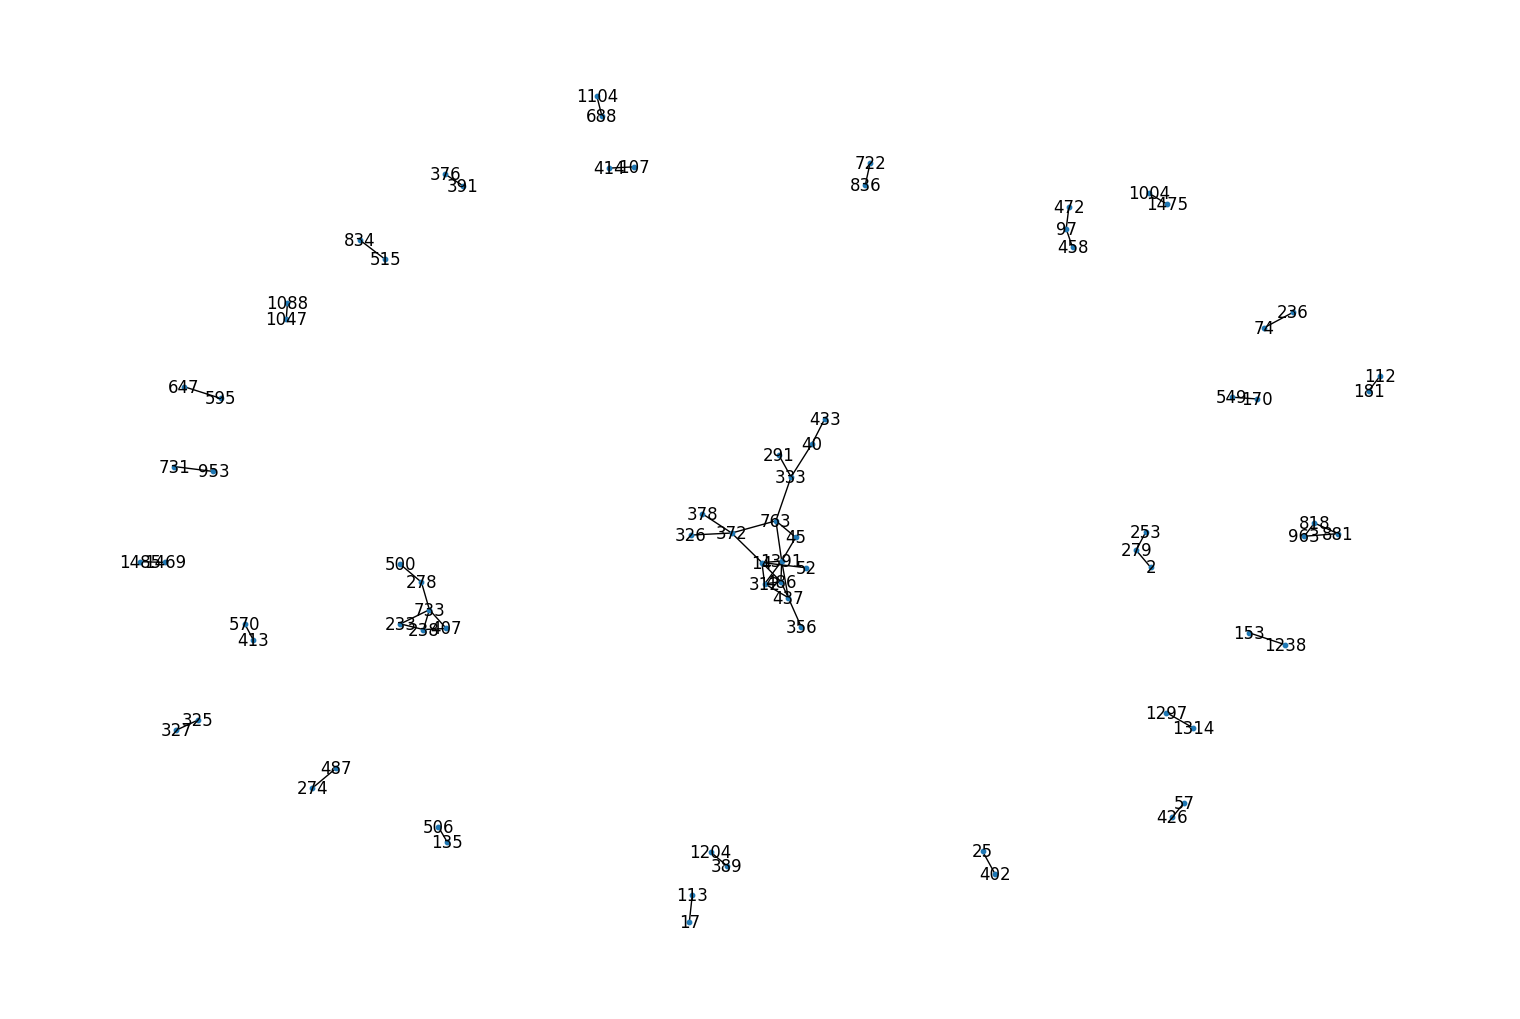

In [28]:

plt.figure(figsize=(15, 10))

# Draw the graph
nx.draw(G, pos=pos,with_labels=True,node_size=10,)

# Show the plot
plt.show()

## Plotly- Interactive Network Graph

In [29]:


edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 =pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')


node_x = []
node_y = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

In [30]:
df_display=df.copy()
df_display["ingredients"]=ingredients_list
df_display

,food,ingredients
0,Ginisang Pusit,"vinegar,peppercorn,leaf,oil,onion,roma_tomatoe..."
1,Polvoron,"flour,cream,milk,sugar,butter,pinipig"
2,Ube Maja Blanca,"coconut,cream,coconut,milk,milk,milk,sugar,ext..."
3,Adobong Talaba,"oil,butter,onion,clove,garlic,ginger,oyster,me..."
4,Miswa at Patola Soup,"oil,onion,ground,pork,fish,noodle,salt,pepper"
...,...,...
1559,Pork with Salted Black Beans,"pork,tenderloin,strip,bean,oyster,sauce,medium..."
1560,Misua with Patola and Shrimp,"sponge,gourd,shrimp,misua,noodle,tomato,onion,..."
1561,Pata Pochero Recipe,"inch,length,bunch,bok_choy,potato,beef,beef,po..."
1562,Basil Chicken Recipe,"basil,sugar,fish,sauce,chili,flake,oil,ground,..."


In [31]:
filtered_all.doc1.iloc[0]

279

In [32]:
node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append(
                    "Recipe Name:" + str(df.loc[adjacencies[0]].food) +"<br>" +
                    "Recipe ID: " + str(adjacencies[0]) +"<br>" + "<br>" +
                
                    "Ingredients:<br>" + df.loc[adjacencies[0]].ingredients.replace(",","<br>") + "<br>"  + "<br>"  #+
                    #"Ingredients:<br>" + df_display.loc[adjacencies[0]].ingredients.replace(",","<br>")
                    )


node_trace.marker.color = node_adjacencies
node_trace.text = node_text

In [33]:

#Layout
fig = go.Figure(data=[edge_trace, node_trace],
            layout=go.Layout(
            #title='Network Of Similar Recipes. Specified Ingredient: ' + ingredient_filter.title() ,
            titlefont_size=16,
            showlegend=False,
            hovermode='closest',
            margin=dict(b=20,l=5,r=5,t=40),
            annotations=[ dict(
                #text="Similarity Threhold: " +str(threshold*100) +"%, Specification:" + f, 
                showarrow=False,
                xref="paper", yref="paper",
                x=0.005, y=-0.002 ) ],
            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
            )

fig.update_layout(height=800, width=1600, 
                    #hovermode="x"
                    )
fig.show()


d:\Eskwelabs\sprint4\dsf-c10-sprint-4\code-along\scripting_101\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

d:\Eskwelabs\sprint4\dsf-c10-sprint-4\code-along\scripting_101\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



## Functions

In [71]:
#Inputs
long_df

,index,variable,value
0,0,0,1.000000
1,1,0,0.000000
2,2,0,0.000000
3,3,0,0.113245
4,4,0,0.247410
...,...,...,...
2446091,1559,1563,0.418091
2446092,1560,1563,0.107522
2446093,1561,1563,0.128018
2446094,1562,1563,0.075853


In [68]:
df

,food,ingredients
0,Ginisang Pusit,"2 pounds squid, 1/2 cup vinegar, 4 cloves garl..."
1,Polvoron,"2 cups flour, 1 cup powdered full cream milk (..."
2,Ube Maja Blanca,"2 cups coconut cream, 2 cans (13.5 ounces each..."
3,Adobong Talaba,"1 tablespoon canola oil, 2 tablespoons butter,..."
4,Miswa at Patola Soup,"3 medium patola, 1 tablespoon canola oil, 1 on..."
...,...,...
1559,Pork with Salted Black Beans,"1 lb. pork tenderloin sliced into thin strips,..."
1560,Misua with Patola and Shrimp,"1 medium sized patola sponge gourd, peeled and..."
1561,Pata Pochero Recipe,"3 lbs. Pig's leg pata, cut in 2 ½ inches lengt..."
1562,Basil Chicken Recipe,"1 lb. ground chicken breast, 12 to 15 pieces f..."


In [81]:
ingredients_list

['vinegar,peppercorn,leaf,oil,onion,roma_tomatoe,fish,sauce,salt,pepper',
 'flour,cream,milk,sugar,butter,pinipig',
 'coconut,cream,coconut,milk,milk,milk,sugar,extract,cornstarch',
 'oil,butter,onion,clove,garlic,ginger,oyster,meat,soy,sauce,salt',
 'oil,onion,ground,pork,fish,noodle,salt,pepper',
 'corn,cobs,corn,kernel,coconut,milk,coconut,cream,sugar',
 'rice,flour,coconut,milk,camote,saba_banana,coconut,cream,sugar',
 'center,pork,loin,rib,chop,bone,inch,pepper,soy,sauce,calamansi,juice,canola,oil',
 'oil,onion,clove,garlic,bone,chicken,part,wing,thigh,breast,salt,ground,pork,onion,chestnut,carrot,clove,soy,sauce,salt,oil,onion,fish,sauce,salt,pepper,onion,bit',
 'fish,sauce,onion,tomato,banana,chili,cut,bean,inch,length,salmon,cut,eggplant,chunk,salt,bok_choy',
 'oil,onion,clove,roast,inch,cube,fish,tomato,chayote,inch,cube,salt,pepper',
 'mussel,olive,oil,head,garlic,thai,chili,pepper,onion,bell,pepper,strip,tomato,sauce,salt,pepper',
 'oil,saba_banana,potato,onion,clove,chicken

In [75]:
#pickle.dump(long_df, open('data/similarity.pkl', "wb"))

df_recipes = pickle.load(open('data/recipe_list.pkl', "rb"))
df_similarities = pickle.load(open('data/similarity.pkl', "rb"))



In [79]:
def network_graph(threshold,ingredient_filter,f=None):
    network_df_long=df_similarities

    filtered_all=network_df_long[(network_df_long.value>=threshold)]
    filtered_all=filtered_all.loc[~(filtered_all['index'] == filtered_all['variable'])]

    filtered_all.columns=["doc1","doc2","similarity_score"]

    filtered_ingredients=df[df_recipes.ingredients.str.contains(ingredient_filter)].index

    if f=="similar":
        filtered_all=filtered_all[(filtered_all.doc1.isin(filtered_ingredients)) & (filtered_all.doc2.isin(filtered_ingredients)) ]
    elif f=="complementary":
        filtered_all=filtered_all[filtered_all.doc1.isin(filtered_ingredients)]
    
    

    

    G = nx.Graph()
    for i in filtered_all.doc1.unique():
        if not G.has_node(i):
            G.add_node(i)
            #G.add_node(i)

    for i in filtered_all.index:
        #print(i)
        if not G.has_edge(filtered_all.loc[i].doc1,filtered_all.loc[i].doc2):
            G.add_edge(filtered_all.loc[i].doc1,filtered_all.loc[i].doc2)



    pos = nx.spring_layout(G)

    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 =pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')


    node_x = []
    node_y = []
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            # colorscale options
            #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
            #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
            #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
            colorscale='YlGnBu',
            reversescale=True,
            color=[],
            size=10,
            colorbar=dict(
                thickness=15,
                title='Node Connections',
                xanchor='left',
                titleside='right'
            ),
            line_width=2))

    df_display=df.copy()
    df_display["ingredients"]=ingredients_list
    df_display

    node_adjacencies = []
    node_text = []
    for node, adjacencies in enumerate(G.adjacency()):
        
        node_adjacencies.append(len(adjacencies[1]))
        node_text.append(
                        "Recipe Name:" + str(df.loc[adjacencies[0]].food) +"<br>" +
                        "Recipe ID: " + str(adjacencies[0]) +"<br>" + "<br>" +
                    
                        "Ingredients:<br>" + df.loc[adjacencies[0]].ingredients.replace(",","<br>") + "<br>"  + "<br>"  #+
                        #"Ingredients:<br>" + df_display.loc[adjacencies[0]].ingredients.replace(",","<br>")
                        )


    node_trace.marker.color = node_adjacencies
    node_trace.text = node_text


    #Layout
    fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                #title='Network Of Similar Recipes. Specified Ingredient: ' + ingredient_filter.title() ,
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    #text="Similarity Threhold: " +str(threshold*100) +"%, Specification:" + f, 
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )

    fig.update_layout(height=800, width=1600, 
                        #hovermode="x"
                        )
    fig.show()

In [80]:
network_graph(0.75,"beef",f="similar")

d:\Eskwelabs\sprint4\dsf-c10-sprint-4\code-along\scripting_101\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

d:\Eskwelabs\sprint4\dsf-c10-sprint-4\code-along\scripting_101\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [ ]:
def network_graph(threshold,ingredient_filter,f=None):

    edge_df=df2[df2.t1_t2_similarity>threshold]
    edge_df["pair"]=edge_df.apply(lambda x: list([x['food1'],x['food2']]),axis=1)  
    edge_df=pd.merge(edge_df,df1[["ingredients","instructions","food"]], how="left", left_on="food1", right_on="food")
    edge_df.drop(columns="food",inplace=True)
    if f=="similar":
        edge_df=edge_df[(edge_df.text1.str.contains(ingredient_filter)) & ( edge_df.text2.str.contains(ingredient_filter))]
    elif f=="complementary":
        edge_df=edge_df[(edge_df.text1.str.contains(ingredient_filter)) | ( edge_df.text2.str.contains(ingredient_filter))]

   

    nodes_df=df1[df1.food.isin(edge_df.food1.tolist()+edge_df.food2.tolist())]
    
    
    G = nx.Graph()
    for count,i in enumerate(nodes_df.food):
        #if df1.sims.iloc[count]>threshold:
        G.add_node(i)


    for count,i in enumerate(edge_df.pair):
        #if df1.sims.iloc[count]>threshold:
        if edge_df.t1_t2_similarity.iloc[count]>=threshold:
            G.add_edge(i[0],i[1])
            #G.add_edge(i[1],i[0])

    pos = nx.spring_layout(G)
    #pos = nx.random_layout(G)

    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 =pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')


    node_x = []
    node_y = []
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            # colorscale options
            #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
            #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
            #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
            colorscale='YlGnBu',
            reversescale=True,
            color=[],
            size=10,
            colorbar=dict(
                thickness=15,
                title='Node Connections',
                xanchor='left',
                titleside='right'
            ),
            line_width=2))


    node_adjacencies = []
    node_text = []
    for node, adjacencies in enumerate(G.adjacency()):
        #print(node)
        
        # node_adjacencies.append(len(adjacencies[1]))
        # #node_text.append('# of connections: '+str(len(adjacencies[1])))
        # #node_text.append('Index: '+str(df1.index[node]))
        # node_text.append('# of connections: '+str(len(adjacencies[1]))+"<br>"+
        #                  'Recipe Name: '+str(nodes_df.food.iloc[node]) +"<br>" + 
        #                 "Ingredients:<br> " + nodes_df.ingredients.iloc[node].replace(",","<br>"))
        
        node_adjacencies.append(len(adjacencies[1])+len(adjacencies[0]))
        #node_text.append('# of connections: '+str(len(adjacencies[1])))
        #node_text.append('Index: '+str(df1.index[node]))
        node_text.append(#'# of connections: '+str(len(adjacencies[1])+len(adjacencies[0]))+"<br>"+
                         'Recipe Name: '+str(nodes_df.food.iloc[node]) +"<br>" + 
                        "Ingredients:<br> " + nodes_df.ingredients.iloc[node].replace(",","<br>"))


    node_trace.marker.color = node_adjacencies
    node_trace.text = node_text
    
    fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='Network Of Similar Recipes. Specified Ingredient: ' + ingredient_filter.title() ,
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="Similarity Threhold: " +str(threshold*100) +"%, Specification:" + f, 
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )

    fig.show()
    return G